# Bullet Journal LLM

I currently use the SuperNote as a [Bullet Journal](https://www.youtube.com/watch?v=fm15cmYU0IM). This
notebook is experimenting with processing the supernote media, using extracted text from note pages,
and determining what we can infer or cleanup about each note.

# Simple Daily Analysis

Look at an arbitrary day's note and see what can be inferred/cleaned up.

In [1]:
from pathlib import Path
import logging
import sys
import yaml

import google.generativeai as genai
import os

_LOGGER = logging.getLogger(__name__)
logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)

NOTES_DIR = Path("../texts")
PAGES_DIR = Path("../pages")
SECRETS = Path("../secrets.yaml")

MODEL_ID = 'gemini-1.5-flash'

secrets = yaml.safe_load(SECRETS.read_text())

genai.configure(api_key=secrets["gemini_api_key"])

_LOGGER.info("Initializing client library")
model = genai.GenerativeModel(MODEL_ID)

INFO:__main__:Initializing client library


/Users/allen/Development/supernote-llm/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
import random

daily_notes = list(NOTES_DIR.glob("Daily-*.txt"))

random.shuffle(daily_notes)
daily_notes[0]

PosixPath('../texts/Daily-16-P20240201073944998430qrrAJQfuUG0J.txt')

In [8]:
with daily_notes[0].open() as f:
    text = f.read()
    print(text)

0201 THU
✗ aot rent
- ai throughput notes
- Bard evcls :/videos?
' Ask Photos user study ,' run synthetic data % lab
notes for synthetic data
* - review Tl Databases slides
wrap up DMA rollout plan
' summarize s nth data next
' monthly reflection
• query lens transitions 1 t 0202 FRI * E serving TPU cal
Tristan email intro
- 15 mins: DMA rollout plan cleanup
1- synth date next steps
1. gap print return label
- At throughput bullet points
. review quality report
0203 SAT, 0204 SUN
- Boo 1-oct flights to LOW
. TP stand
Fill cavity endar * .


In [17]:
OCR_PROMPT = """You are analyzing OCR text from an e-ink SuperNote A5X. The text has been extract
automatically by the device and is not perfect. You can see that the text is not perfect
and will need some cleaning up. The text is in English and is in a bullet journal format.
The bullet journal can contain a variety of different types of information, such as
notes, to-do lists, and reminders. 


An entry in a daily journal can have different types of bullets:
o event
. task
x completed task
- note
< moved to future log
> moved to another daily, weekly, or monthly note

Here are examples of what a daily note looks like:

1030 SUN
o Halloween Party @ 7PM @ Kid's school 
. Pick up candy
x Buy pumpkins
> Call mom

1031 MON
- Trickortreaters were so cute
. Call mom


Your task is to rewrite the journal in a consistent format and fix mistakes in
the OCR. Only answer with the corrected text, and no other commentary, as the
answer will be programtically parsed

Original OCR text {filename}:
{note}

Corrected bullet journal:
"""

response = model.generate_content(OCR_PROMPT.format(note=text, filename=str(daily_notes[0])))

In [18]:
print(response.text)

0201 THU
x paid rent
- AI throughput notes
- Bard evcls :/videos?
- Ask Photos user study, run synthetic data % lab
notes for synthetic data
- review TL Databases slides
- wrap up DMA rollout plan
- summarize synthetic data next
- monthly reflection
- query lens transitions 1 to 0202 FRI * E serving TPU calc
- Tristan email intro
- 15 mins: DMA rollout plan cleanup
- synth data next steps
- gap print return label
- AI throughput bullet points
- review quality report
0203 SAT, 0204 SUN
- Book 1-oct flights to LOW
- TP stand
- Fill cavity calendar * 



In [27]:
import PIL.Image

page_filename = PAGES_DIR / ("_".join(daily_notes[0].name.split("-")[0:2]) + ".png")
page_png = PIL.Image.open(page_filename)

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 65536


In [31]:


IMG_PROMPT = """You are analyzing OCR text from an e-ink SuperNote A5X. The note is hand
written. You can see that the text is not perfect and will need some cleaning up. The
text is in English and is in a bullet journal format. The bullet journal can contain a
variety of different types of information, such as notes, to-do lists, and reminders. 

An entry in a daily journal can have different types of bullets:
  o event
  . task
  x completed task
  - note
  < moved to future log
  > moved to another daily, weekly, or monthly note
*   important (can be added left of another bullet)

Here are examples of what a daily note looks like:

1030 SUN
  o Halloween Party @ 7PM @ Kid's school 
  . Pick up candy
  x Buy pumpkins
* > Call mom

1031 MON
  - Trickortreaters were so cute
  . Call mom


Your task is to rewrite the journal in a consistent format and fix mistakes in
the OCR. Only answer with the corrected text, and no other commentary, as the
answer will be programtically parsed
"""

response = model.generate_content([IMG_PROMPT, page_png])

In [32]:
print(response.text)

0201 THU
x act rent
< ai through put notes
- Board overview/videos?
*x Ask Photos user study
**x run Synthetic data colab 
**x notes for Synthetic data
**x review TT Databases slides
*x Wrap up DMA rollout plan
x Summarize synth data next
< monthly reflection
* < query lens transitions

0202 FRI
**< Serving TPU calendar
*x Tristan email intro 
*x 15 mins; DMA rollout plan Cleanup
*x synth data next steps
x gap print return label
*x AI through put bullet points
*x review quality report

0203 SAT 0204 SUN
- Booked flights to LOW
*x TP stand
* > Fill cavity 



## Daily notes

- Model is able to understand the bullet journal format well
- Model awas able to improves the detected OCR
- Using the multi-modal model directly for OCR works even better than the supernote OCR

# Monthly


In [3]:
weekly_pages = sorted(list(PAGES_DIR.glob("Weekly_*.png")))
recent_pages = weekly_pages[-3:]

recent_pages


[PosixPath('../pages/Weekly_34.png'),
 PosixPath('../pages/Weekly_35.png'),
 PosixPath('../pages/Weekly_36.png')]

In [6]:
import PIL.Image

weekly_pngs = [
    PIL.Image.open(page_filename)
    for page_filename in recent_pages
]

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 62146
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 58473
DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 30482


In [7]:

IMG_PROMPT = """You are analyzing OCR text from an e-ink SuperNote A5X. The note is hand
written. You can see that the text is not perfect and will need some cleaning up. The
text is in English and is in a bullet journal format. The bullet journal can contain a
variety of different types of information, such as notes, to-do lists, and reminders. 

An entry in a weekly journal can have different types of bullets:
  o event
  . task
  x completed task
  - note
  < moved to future log
  > moved to another daily, weekly, or monthly note
*   important (can be added left of another bullet)

There is also a special page which is a "Weekly Review" for a date range. This
is usualy in the format of some prompt questions to allow for reflection on
the previous week as well as the week ahead, and is usually based on shorter
term view of longer term goals, projects, or values.


Here are examples of what a weekly note looks like:



WEEKLY REVIEW 0123-0129

1. What did I accomplish last week?
- After completing the salary analysis, i got assigned to do the final report
- I also got a lot of positive feedback from the team on the presentation
2. What were my biggest challenges?
- I had a hard time getting the data for the salary report
- Perhaps I should consider asking for help
3. What are my goals for next week?
- Make sure i talk to at least one parent
- Finish the salary report


WEEKLY 0130-0205

Personal
  . Go to the gym 3x . . .
  . Call mom

Work
  x Initial draft of salary report
  . Check if Kendra is available to meet this week
  . Send out report by Wednesday
  

Your task is to rewrite the journal in a consistent format and fix mistakes in
the OCR. Only answer with the corrected text, and no other commentary, as the
answer will be programtically parsed.
"""

response = model.generate_content([IMG_PROMPT, *weekly_pngs])

In [9]:
print(response.text)

WEEKLY REVIEW 0527-0602

- What progress did I make last week?
  - learned about gemeni extension
  - home restart evals
  - golf w/ Quentin 
  - Auto rater deep dive at next GCP + snap ideas
- Where can I streamline, declutter?
  - make home assistant evals simpler -> automated device check?
  - Go scrappy on gemeni integration
- Did I practice compassion this week?
  - Care for myself, alcohol break
  - Shruthi in good sha before ex.

WEEKLY 0527-0602

- AI/ML
  - review model metrics
  - review temporal memories
  - long context framing
  - serving utilization

- ATL
  - AI tech talks w/ Rohan
  - Targets w/ PARM: ping Hixon
  - PD.D + Debajit
  - Debajit + Photos

- Log
  x Dishwasher panel FGLD 2466
  x The Cold activation 
  - credit geometry Honors & FTA
  - Betsy Photos on computer
  - Assemble bench
  - water softener salt

WEEKLY 0603-0609

- AI/ML
  * Key tech questions for floary
    - Ask Photos GTM plan next steps

- ATL & cost
  - Play business driver summary
  - Grad fe

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 41 58473


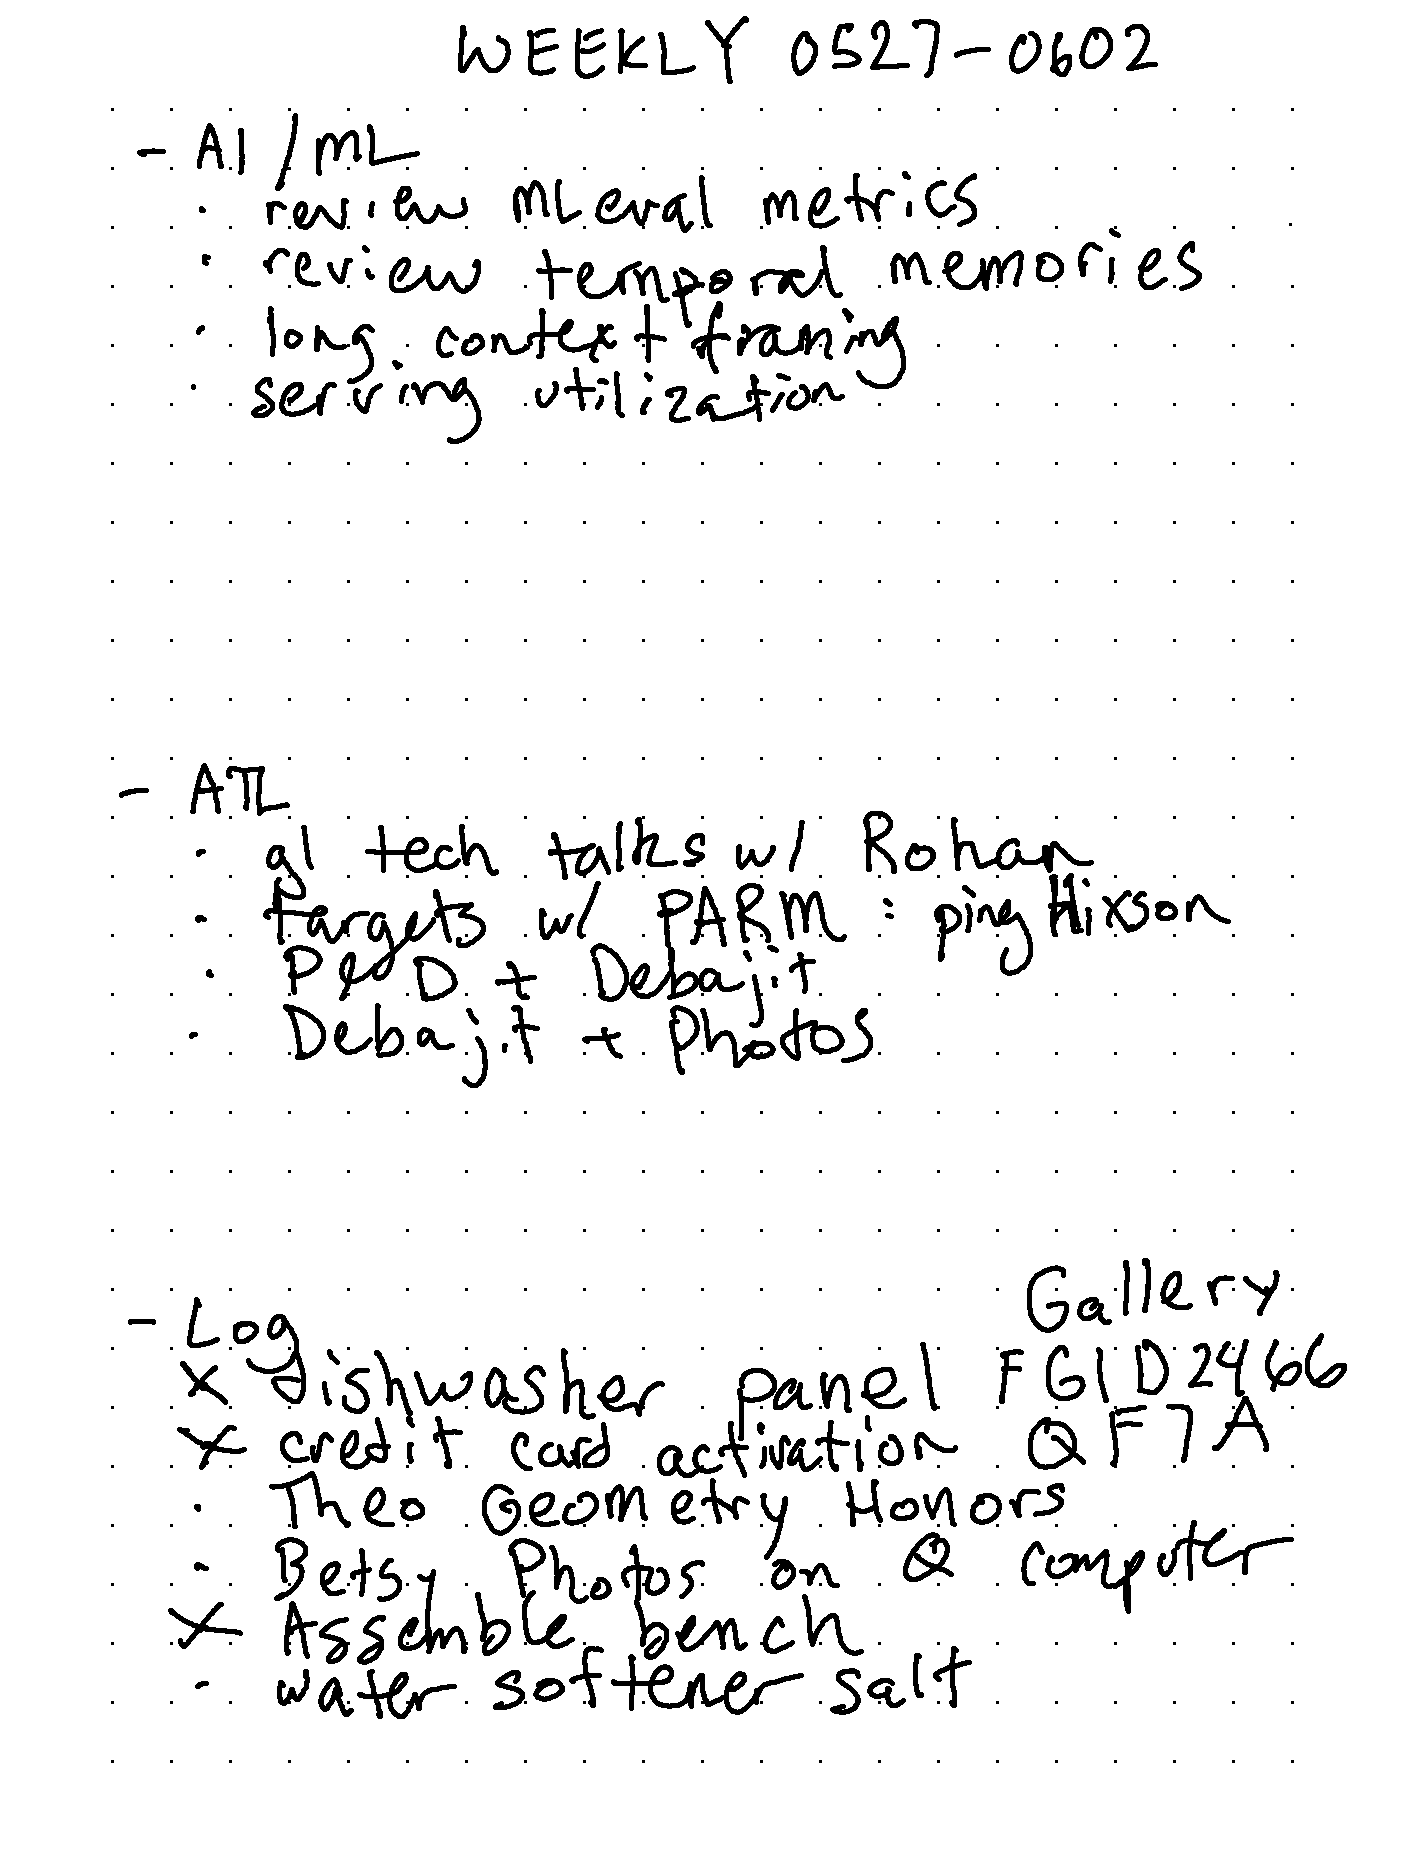

In [11]:
from IPython.display import display

display(PIL.Image.open(recent_pages[-2]))